<style>
    rd { color:red; }
    bl { color:blue; }
</style>

# 특별한 가공이나 하이퍼파라미터 조작 없는 순정 XGBoost
## 전처리
| 작업        | 대상                                                                                       |
|:------------|:-------------------------------------------------------------------------------------------|
| 컬럼 삭제   | "RowNumber", "CustomerId", "Surname"                                                       |
| 컬럼 인코딩 | "Geography", "Gender"                                                                      |
| 컬럼 라벨링 | "CreditScore", "Geography", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary" |

### 스케일링 : StandardScaler

## 하이퍼파라미터
- XGBoost
    - 조작없는 순정

In [24]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns

import matplotlib
import matplotlib.font_manager as fm

import re

import xgboost
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, LabelEncoder

import xgboost as xgb
from xgboost import plot_importance, XGBClassifier

In [25]:
def encoding(df:pd.DataFrame, columns:list[str]):
    """범주형 데이터를 인코딩"""

    encoder_list = {}
    result_df    = df.copy(deep=True)

    for col_nm in columns:
        encoder           = LabelEncoder()
        result_df[col_nm] = encoder.fit_transform(result_df[col_nm])

        encoder_list[col_nm] = encoder

    return result_df, encoder_list


def scaling(df:pd.DataFrame, columns:list[str]):
    """DataFrame 에서 컬럼들을 스케일링"""

    scaler    = StandardScaler()
    result_df = df.copy(deep=True)

    result_df[columns] = scaler.fit_transform(result_df[columns])

    return result_df

## 데이터 로드 및 전처리

In [ ]:
######################################### 데이터 로드
df     = pd.read_csv("../data/Churn_Modelling.csv")
inputs = df.drop(columns=["Exited"], axis=1)
labels = df["Exited"]


######################################### 데이터 전처리
_input = inputs.drop(columns=["RowNumber", "CustomerId", "Surname"], axis=1)     # 컬럼 삭제( Rownumber, CustomerId, Surname )
_input, encoders = encoding(_input, ["Geography", "Gender"])            # 범주형 문자열 데이터 인코딩
_input = scaling(_input, ["CreditScore", "Geography", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"])

In [ ]:
print(_input.info(), "\n")

In [28]:
print(_input.value_counts(), "\n")

CreditScore  Geography  Gender  Age        Tenure     Balance    NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary
 2.063884     1.515067  1        3.058772   1.724464  -0.110230  -0.911583      1          0               -0.038201          1
-3.109504    -0.901886  0        0.102810  -1.733315   0.554746  -0.911583      1          1                1.256024          1
                                 2.009882  -0.695982  -1.225848  -0.911583      0          0                0.238332          1
                        1        1.151700   1.724464  -1.225848  -0.911583      1          1                0.447481          1
              0.306591  1        0.007457  -1.733315   0.532858   0.807737      0          0                0.408848          1
                                                                                                                             ..
-2.581819     0.306591  1        0.865639   1.032908   0.827869  -0.911583      1          0                1

## 데이터 분할

In [29]:
######################################### 데이터 분할. random_state 지정한 상태에서 성능 확인/개선해보고, state 풀었을 때도 보기.
train_x, test_x, train_y, test_y = train_test_split(_input, labels, stratify=labels)
print("학습 데이터 shape : ", train_x.shape, train_y.shape)
print("검증 데이터 shape : ",  test_x.shape,  test_y.shape, "\n")

학습 데이터 shape :  (7500, 10) (7500,)
검증 데이터 shape :  (2500, 10) (2500,) 



## 모델 학습 및 평가 - n_estimators=400, learning_rate=0.1, max_depth=5
RandomForest 에 비해 성능이 하락함.

In [30]:
# 데이터 wrapping
# dtrain_x = xgb.DMatrix(train_x, train_y)
# dtest_x  = xgb.DMatrix(test_x , test_y)

######################################### 모델 학습
# params = {'max_depth'       : 5,
#           'eta'             : 0.1,
#           'objective'       : 'binary:logistic',
#           'eval_metric'     : 'logloss',
#           'early_stoppings' : 100
# }
# model = xgb.train(params=params, dtrain=dtrain_x, num_boost_round=400, evals=[(dtrain_x, "train"), (dtest_x, "eval")])
model = XGBClassifier(n_estimators=500, learning_rate=0.005, max_depth=5)             # 0.85
# model = XGBClassifier(n_estimators=400, learning_rate=0.1, booster="gblinear")    # 0.80
model.fit(train_x, train_y)


######################################### 모델 성능 평가
predicted = model.predict(test_x)
print(classification_report(test_y, predicted, target_names=["Stayed", "Exited"]))

              precision    recall  f1-score   support

      Stayed       0.87      0.97      0.92      1991
      Exited       0.80      0.41      0.54       509

    accuracy                           0.86      2500
   macro avg       0.83      0.69      0.73      2500
weighted avg       0.85      0.86      0.84      2500



## XGBoost plot_importance 로 특성중요도 확인

[0.02207433 0.07780215 0.04688581 0.24197231 0.01833927 0.04840684
 0.2515047  0.00348741 0.26932737 0.02019979]


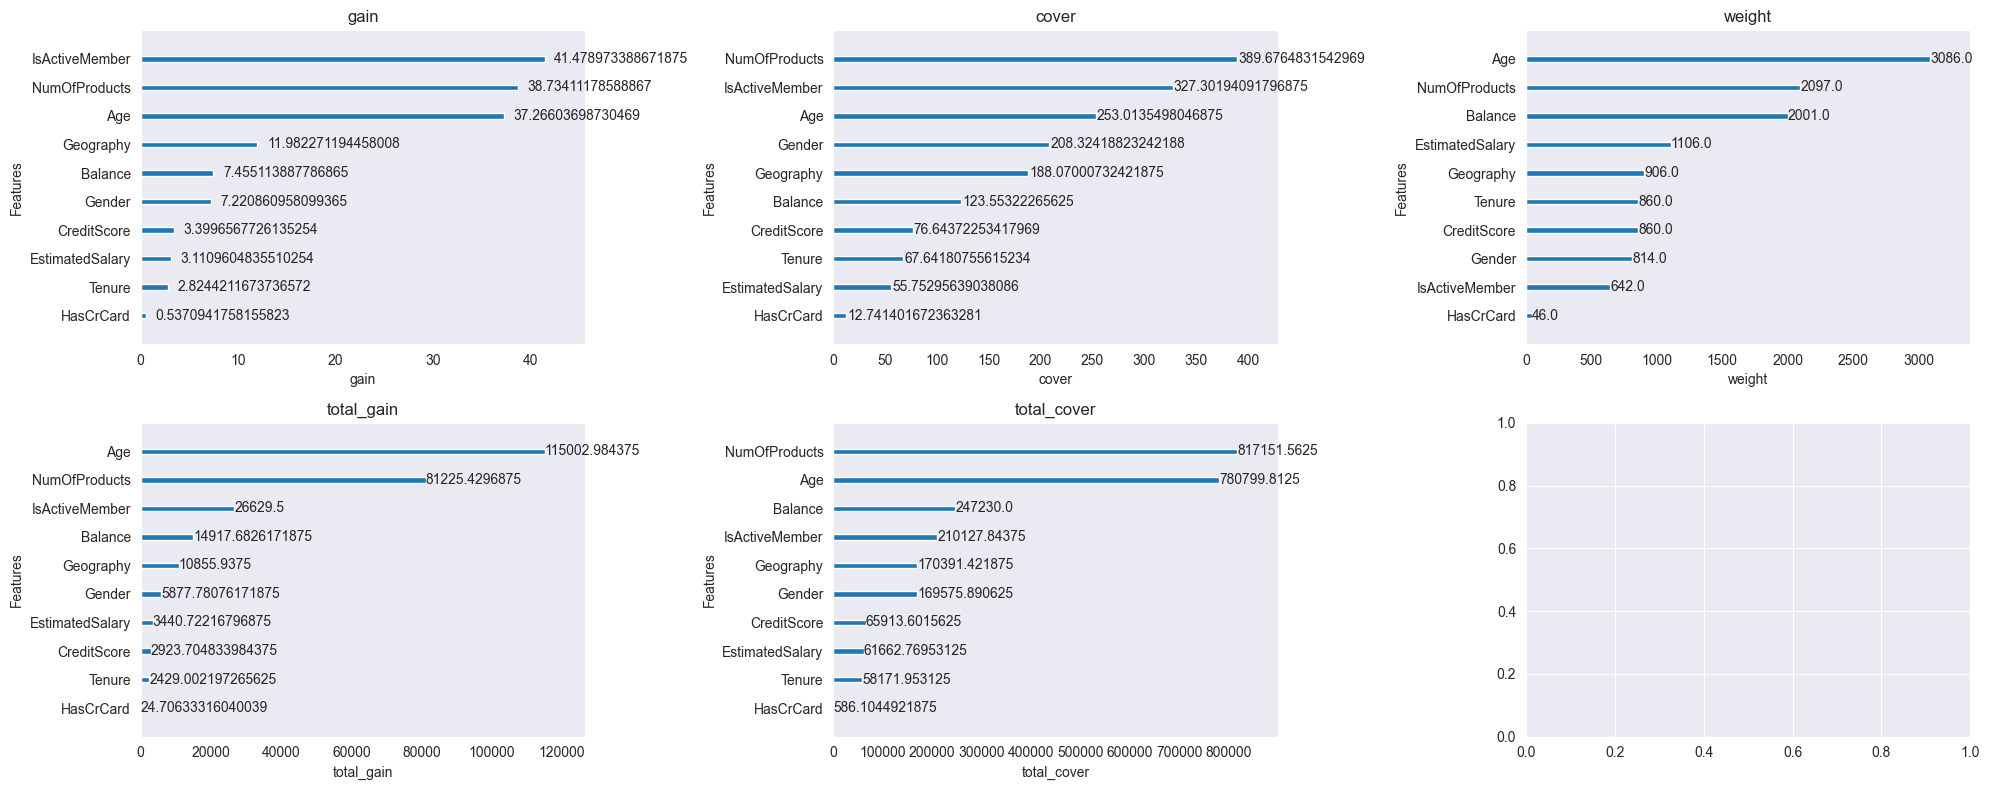

In [34]:
fig, ax = plt.subplots(2, 3, figsize=(20,8))

types = ["gain", "cover", "weight", "total_gain", "total_cover"]
for i, _type in enumerate(types):
    xgboost.plot_importance(model, importance_type=_type, title=_type, xlabel=_type, grid=False, ax=ax[i//3][i%3])

print(model.feature_importances_)

plt.tight_layout()
plt.show()

### XGBoost plot_importance 확인 결과
- 하위 40% 에 들어가는 속성들 모음( 정렬 )
    - Gain        : ["CreditScore", "EstimatedSalary", "Tenure", "HasCrCard" ]
    - Cover       : ["CreditScore", "EstimatedSalary", "Tenure", "HasCrCard" ]
    - Weight      : ["CreditScore", "IsActiveMember" , "Gender", "HasCrCard" ]
    - Total_gain  : ["CreditScore", "EstimatedSalary", "Tenure", "HasCrCard" ]
    - Total_cover : ["CreditScore", "EstimatedSalary", "Tenure", "HasCrCard" ]

- 상위 30% 에 들어가는 속성들 모음( 정렬 )
    - Gain        : ["IsActiveMember", "NumOfProducts", "Age" ]
    - Cover       : ["IsActiveMember", "NumOfProducts", "Age" ]
    - Weight      : ["Balance"       , "NumOfProducts", "Age" ]
    - Total_gain  : ["IsActiveMember", "NumOfProducts", "Age" ]
    - Total_cover : ["Balance"       , "NumOfProducts", "Age" ]

1. HasCrCard 는 어느 그래프에서도 중요도가 낮음.
2. CreditScore, EstimatedSalary, Tenure 는 여러 immportance type 에서 중요도가 낮음.